In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [3]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)

X = HMDA_encoded.drop(columns=['loan_granted'])
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 18) (136310, 18) (170388, 18)
(545238,) (136310,) (170388,)


In [5]:
y_train.dtype

dtype('int32')

In [6]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_df.head()

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
0    -1.448136       0.355598             1.551546             -0.729559   
1     0.443058      -0.000074            -0.000527             -0.729559   
2     0.439507      -0.000074            -0.000527             -0.729559   
3     0.439507      -0.000074            -0.000527             -0.729559   
4    -1.437900       2.020717            -1.035981             -0.729559   

   applicant_race-1_White  loan_type_FHA  loan_type_VA  loan_type_FSA/RHS  \
0                0.427279      -0.342862      3.629675          -0.092947   
1               -2.340392      -0.342862     -0.275507          -0.092947   
2                0.427279      -0.342862     -0.275507          -0.092947   
3                0.427279      -0.342862     -0.275507          -0.092947   
4                0.427279      -0.342862     -0.275507          -0.092947   

   debt_to_income_ratio_20%-<30%  debt_to_income_ratio_30%-<36%-41%%  \
0                       -0.36104                           -0.353484   
1                       -0.36104                           -0.353484   
2                       -0.36104                           -0.353484   
3                       -0.36104                           -0.353484   
4                       -0.36104                            2.828979   

   debt_to_income_ratio_36%-41%  debt_to_income_ratio_41%-45%  \
0                     -0.410871                     -0.348057   
1                     -0.410871                     -0.348057   
2                     -0.410871                     -0.348057   
3                     -0.410871                     -0.348057   
4                     -0.410871                     -0.348057   

   debt_to_income_ratio_46%-49%  debt_to_income_ratio_50%-60%  \
0                     -0.303503                      3.836273   
1                      3.294859                     -0.260670   
2                     -0.303503                     -0.260670   
3                     -0.303503                     -0.260670   
4                     -0.303503                     -0.260670   

   debt_to_income_ratio_<20%  debt_to_income_ratio_>60%  \
0                  -0.222307                  -0.206629   
1                  -0.222307                  -0.206629   
2                  -0.222307                  -0.206629   
3                   4.498276                  -0.206629   
4                  -0.222307                  -0.206629   

   debt_to_income_ratio_missing  lien_status_Subordinate lien  
0                     -0.594753                     -0.405707  
1                     -0.594753                     -0.405707  
2                      1.681372                      2.464834  
3                     -0.594753                     -0.405707  
4                     -0.594753                      2.464834

In [7]:
pd.Series(data = [1 if val < 1 else 0 for val in y_train], name = 'S_Train')

0         0
1         1
2         1
3         0
4         0
         ..
545233    1
545234    1
545235    0
545236    0
545237    1
Name: S_Train, Length: 545238, dtype: int64

In [8]:
'''from fairgbm import FairGBMClassifier

core_lgbm_params = {
    "n_estimators": 200,
    "random_state": 69,
    "n_jobs": -2,
}

fairgbm_clf = FairGBMClassifier(
    constraint_type="FNR",    
    multiplier_learning_rate=0.2,
    constraint_fnr_slack=0.05,
    **core_lgbm_params,
)

S_train = pd.Series(data = [1 if val < 1 else 0 for val in y_train], name = 'S_train')

fairgbm_clf.fit(X_train_df, y_train, constraint_group=S_train)'''

'from fairgbm import FairGBMClassifier\n\ncore_lgbm_params = {\n    "n_estimators": 200,\n    "random_state": 69,\n    "n_jobs": -2,\n}\n\nfairgbm_clf = FairGBMClassifier(\n    constraint_type="FNR",    \n    multiplier_learning_rate=0.2,\n    constraint_fnr_slack=0.05,\n    **core_lgbm_params,\n)\n\nS_train = pd.Series(data = [1 if val < 1 else 0 for val in y_train], name = \'S_train\')\n\nfairgbm_clf.fit(X_train_df, y_train, constraint_group=S_train)'

In [9]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)
BLD_val_df = pd.get_dummies(HMDA_clean_final.loc[X_val.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)
BLD_test_df = pd.get_dummies(HMDA_clean_final.loc[X_test.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [10]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

for col in BLD_val_df.columns:
    if BLD_val_df[col].dtype == 'bool':
        BLD_val_df[col] = BLD_val_df[col].astype(int)

for col in BLD_test_df.columns:
    if BLD_test_df[col].dtype == 'bool':
        BLD_test_df[col] = BLD_test_df[col].astype(int)

In [11]:
BLD_train_df.head()

county_code  interest_rate  loan_to_value_ratio  loan_granted  \
115410       30013       4.990000           100.000000             1   
630420       48119       4.560661            71.241202             0   
612581       48085       4.560661            71.241202             0   
670964       48085       4.560661            71.241202             1   
179727       30111       7.000000            52.055000             1   

        applicant_sex_Male  applicant_sex_Female  \
115410                   1                     0   
630420                   1                     0   
612581                   1                     0   
670964                   1                     0   
179727                   1                     0   

        applicant_race-1_Black or African American  applicant_race-1_White  \
115410                                           0                       1   
630420                                           1                       0   
612581                                           0                       1   
670964                                           0                       1   
179727                                           0                       1   

        loan_type_Conventional  loan_type_FHA  ...  \
115410                       0              0  ...   
630420                       1              0  ...   
612581                       1              0  ...   
670964                       1              0  ...   
179727                       1              0  ...   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
115410                                   0                             0   
630420                                   0                             0   
612581                                   0                             0   
670964                                   0                             0   
179727                                   1                             0   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
115410                             0                             0   
630420                             0                             1   
612581                             0                             0   
670964                             0                             0   
179727                             0                             0   

        debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
115410                             1                          0   
630420                             0                          0   
612581                             0                          0   
670964                             0                          1   
179727                             0                          0   

        debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
115410                          0                             0   
630420                          0                             0   
612581                          0                             1   
670964                          0                             0   
179727                          0                             0   

        lien_status_First lien  lien_status_Subordinate lien  
115410                       1                             0  
630420                       1                             0  
612581                       0                             1  
670964                       1                             0  
179727                       0                             1  

[5 rows x 24 columns]

In [12]:
BLD_train_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_train_df.pkl")
BLD_val_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_val_df.pkl")
BLD_test_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_test_df.pkl")

In [13]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[inFairness]'


In [14]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [15]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [16]:
class_weights_array = dataset_transf_train.instance_weights

In [17]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(metric_orig_train.disparate_impact())
print(metric_transf_train.disparate_impact())

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

0.7528037780827889
0.9999999999999997
Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [18]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [19]:
X_train.astype(float).describe()

county_code  interest_rate  loan_to_value_ratio  \
count  545238.000000  545238.000000        545238.000000   
mean    43877.231382       4.560750            71.250975   
std      9573.854372       1.207122            18.529292   
min     22001.000000       0.000000             0.000000   
25%     48029.000000       4.560661            71.241202   
50%     48201.000000       4.560661            71.241202   
75%     48439.000000       4.740000            78.247750   
max     49057.000000      18.990000           250.000000   

       applicant_sex_Female  applicant_race-1_White  loan_type_FHA  \
count         545238.000000           545238.000000  545238.000000   
mean               0.347368                0.845618       0.105189   
std                0.476134                0.361315       0.306797   
min                0.000000                0.000000       0.000000   
25%                0.000000                1.000000       0.000000   
50%                0.000000                1.000000       0.000000   
75%                1.000000                1.000000       0.000000   
max                1.000000                1.000000       1.000000   

        loan_type_VA  loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
count  545238.000000      545238.000000                  545238.000000   
mean        0.070549           0.008565                       0.115318   
std         0.256070           0.092151                       0.319406   
min         0.000000           0.000000                       0.000000   
25%         0.000000           0.000000                       0.000000   
50%         0.000000           0.000000                       0.000000   
75%         0.000000           0.000000                       0.000000   
max         1.000000           1.000000                       1.000000   

       debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
count                       545238.000000                 545238.000000   
mean                             0.111073                      0.144432   
std                              0.314222                      0.351528   
min                              0.000000                      0.000000   
25%                              0.000000                      0.000000   
50%                              0.000000                      0.000000   
75%                              0.000000                      0.000000   
max                              1.000000                      1.000000   

       debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
count                 545238.000000                 545238.000000   
mean                       0.108054                      0.084345   
std                        0.310449                      0.277905   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                        1.000000                      1.000000   

       debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
count                 545238.000000              545238.000000   
mean                       0.063625                   0.047093   
std                        0.244085                   0.211838   
min                        0.000000                   0.000000   
25%                        0.000000                   0.000000   
50%                        0.000000                   0.000000   
75%                        0.000000                   0.000000   
max                        1.000000                   1.000000   

       debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
count              545238.000000                 545238.000000   
mean                    0.040947                      0.261301   
std                     0.198168                      0.439344   
min          

In [20]:

directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_rew = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_checkpoint_rew = ModelCheckpoint('best_model_rew.hdf5', save_best_only=True, monitor='val_loss', mode='min')


model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model_rew = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 29s 2ms/step - loss: 0.3460 - accuracy: 0.8755 - val_loss: 0.3023 - val_accuracy: 0.8940
Epoch 2/30
11360/11360 [==============================] - 38s 3ms/step - loss: 0.3051 - accuracy: 0.8922 - val_loss: 0.2976 - val_accuracy: 0.8934
Epoch 3/30
11360/11360 [==============================] - 37s 3ms/step - loss: 0.2996 - accuracy: 0.8946 - val_loss: 0.2881 - val_accuracy: 0.8986
Epoch 4/30
11360/11360 [==============================] - 52s 5ms/step - loss: 0.2951 - accuracy: 0.8966 - val_loss: 0.2824 - val_accuracy: 0.9027
Epoch 5/30
11360/11360 [==============================] - 52s 5ms/step - loss: 0.2924 - accuracy: 0.8975 - val_loss: 0.2866 - val_accuracy: 0.8997
Epoch 6/30
11360/11360 [==============================] - 53s 5ms/step - loss: 0.2898 - accuracy: 0.8986 - val_loss: 0.2842 - val_accuracy: 0.8993
Epoch 7/30
11360/11360 [==============================] - 29s 3ms/step - loss: 0.2904 - accuracy: 0.8984 - val_loss: 0

In [22]:
# show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [23]:
model_rew.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_rew = model_rew.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping_rew, model_checkpoint_rew], sample_weight=class_weights_array)

Epoch 1/30
11360/11360 [==============================] - 30s 3ms/step - loss: 0.3439 - accuracy: 0.8774 - val_loss: 0.3039 - val_accuracy: 0.8927
Epoch 2/30
11360/11360 [==============================] - 46s 4ms/step - loss: 0.3039 - accuracy: 0.8937 - val_loss: 0.2993 - val_accuracy: 0.8937
Epoch 3/30
11360/11360 [==============================] - 45s 4ms/step - loss: 0.2994 - accuracy: 0.8950 - val_loss: 0.2938 - val_accuracy: 0.8971
Epoch 4/30
11360/11360 [==============================] - 48s 4ms/step - loss: 0.2966 - accuracy: 0.8965 - val_loss: 0.2837 - val_accuracy: 0.9022
Epoch 5/30
11360/11360 [==============================] - 46s 4ms/step - loss: 0.2953 - accuracy: 0.8971 - val_loss: 0.2902 - val_accuracy: 0.8963
Epoch 6/30
11360/11360 [==============================] - 46s 4ms/step - loss: 0.2949 - accuracy: 0.8975 - val_loss: 0.2867 - val_accuracy: 0.9019
Epoch 7/30
11360/11360 [==============================] - 46s 4ms/step - loss: 0.2950 - accuracy: 0.8976 - val_loss: 0

5325/5325 - 4s - loss: 0.2787 - accuracy: 0.9049 - 4s/epoch - 742us/step


5325/5325 - 4s - loss: 0.2840 - accuracy: 0.9025 - 4s/epoch - 796us/step

Test accuracy: 0.9048935174942017

Test accuracy reweighted: 0.9024931192398071


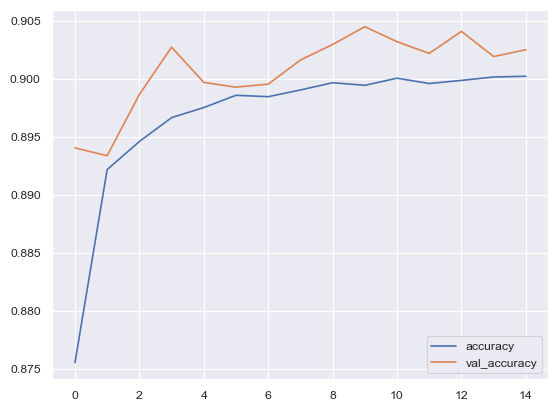

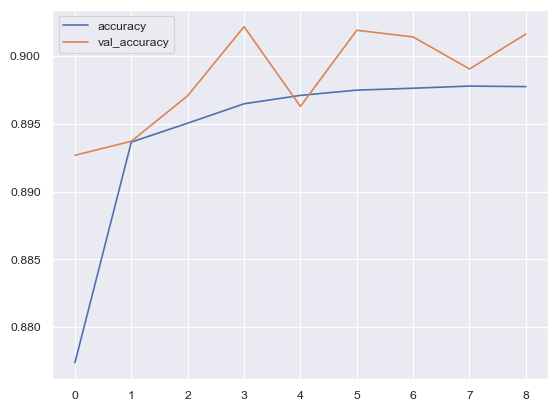

In [24]:
history_df = pd.DataFrame(history.history)
history_df_rew = pd.DataFrame(history_rew.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
history_df_rew.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
test_loss_rew, test_acc_rew = model_rew.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest accuracy reweighted:', test_acc_rew)

In [25]:
history_df

loss  accuracy  val_loss  val_accuracy
0   0.346028  0.875513  0.302321      0.894021
1   0.305092  0.892157  0.297618      0.893353
2   0.299563  0.894574  0.288089      0.898628
3   0.295103  0.896636  0.282377      0.902707
4   0.292379  0.897503  0.286577      0.899670
5   0.289791  0.898560  0.284166      0.899259
6   0.290445  0.898441  0.284575      0.899523
7   0.289276  0.899018  0.283527      0.901599
8   0.288360  0.899644  0.281327      0.902942
9   0.288822  0.899420  0.278483      0.904475
10  0.287754  0.900034  0.281713      0.903177
11  0.288720  0.899574  0.280737      0.902171
12  0.288754  0.899844  0.279237      0.904072
13  0.288284  0.900137  0.282550      0.901900
14  0.288478  0.900200  0.281834      0.902487

5325/5325 [==============================] - 5s 909us/step
[[58374 13274]
 [ 2931 95809]]
[[57967 13681]
 [ 2933 95807]]
Accuracy: 0.9048935371035519
Precision: 0.8783128443478819
Recall: 0.9703159813652016
F1 Score: 0.9220249924214357
Accuracy reweighted: 0.9024931333192479
Precision reweighted: 0.8750456671050709
Recall reweighted: 0.9702957261494835
F1 Score reweighted: 0.9202124594194825
AUC: 0.9439707310493188
AUC reweighted: 0.9419405411065762


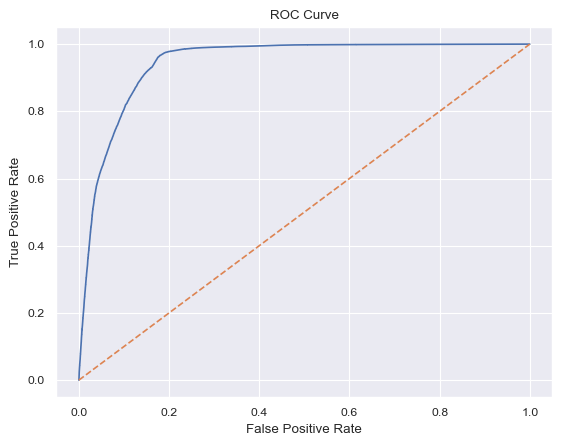

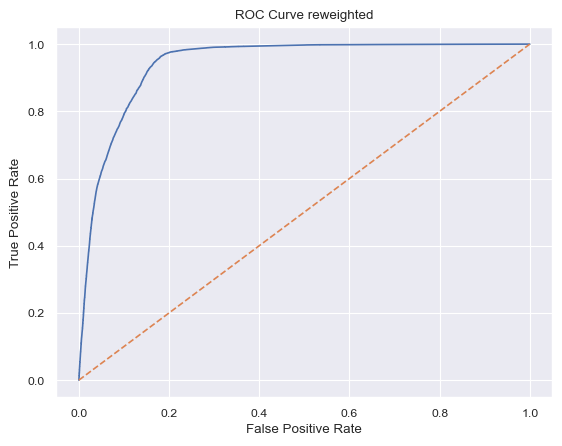

In [26]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

y_pred_proba_rew = model_rew.predict(X_test_scaled)
y_pred_rew = (y_pred_proba_rew > 0.5)
y_pred_proba_rew = y_pred_proba_rew.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

cm_rew = confusion_matrix(y_test, y_pred_rew)
print(cm_rew)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("Accuracy reweighted:", accuracy_score(y_test, y_pred_rew))
print("Precision reweighted:", precision_score(y_test, y_pred_rew))
print("Recall reweighted:", recall_score(y_test, y_pred_rew))
print("F1 Score reweighted:", f1_score(y_test, y_pred_rew))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fprr, tprr, thresholdsr = roc_curve(y_test, y_pred_proba_rew)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

print("AUC reweighted:", roc_auc_score(y_test, y_pred_proba_rew))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.plot(fprr, tprr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve reweighted')
plt.show()

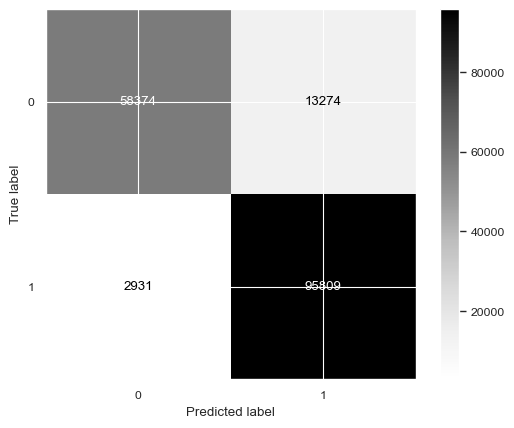

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm).plot(values_format='d', cmap="Greys")

In [28]:
print(cm)

[[58374 13274]
 [ 2931 95809]]


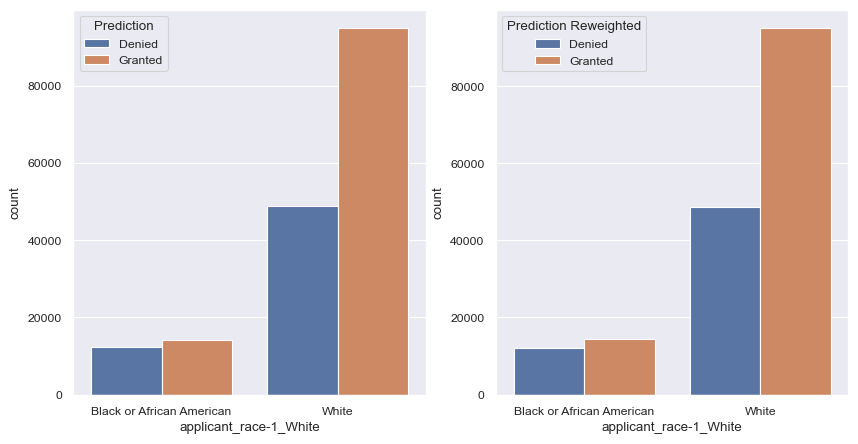

In [29]:
prediction_df = X_test.copy()
prediction_df['prediction'] = y_pred
prediction_df['prediction_proba'] = y_pred_proba
prediction_df['prediction_rew'] = y_pred_rew
prediction_df['prediction_proba_rew'] = y_pred_proba_rew

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.subplot(1, 2, 2)
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction_rew")
plt.legend(title = "Prediction Reweighted", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

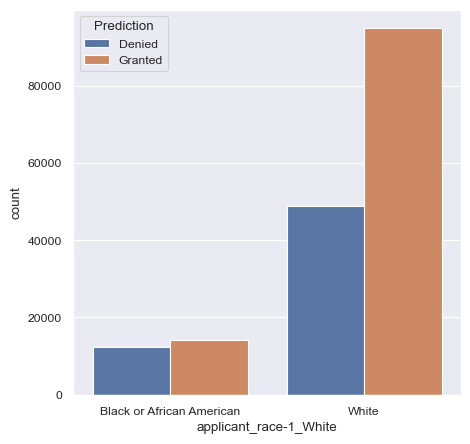

In [30]:
plt.figure(figsize=(5, 5))
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

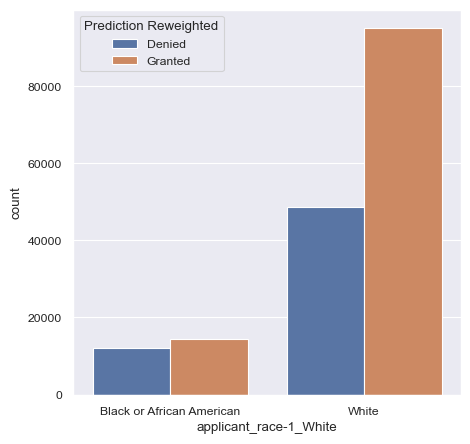

In [31]:
plt.figure(figsize=(5, 5))
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction_rew")
plt.legend(title = "Prediction Reweighted", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

In [32]:
prediction_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/prediction_pre_store/prediction_df_orig_rew.pkl")

In [33]:
pred_bld = BinaryLabelDataset(df=prediction_df, label_names=['prediction'], protected_attribute_names=['applicant_race-1_White'], favorable_label=1.0, unfavorable_label=0.0)
pred_bld_rew = BinaryLabelDataset(df=prediction_df, label_names=['prediction_rew'], protected_attribute_names=['applicant_race-1_White'], favorable_label=1.0, unfavorable_label=0.0)

metric_orig_pred = BinaryLabelDatasetMetric(pred_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_pred_rew = BinaryLabelDatasetMetric(pred_bld_rew, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_pred.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_pred_rew.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.127015
Difference in mean outcomes between unprivileged and privileged groups - Race = -0.119089


In [34]:
X_test

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
238575       48167       3.625000            96.404000                 False   
328268       49035       4.560661            71.241202                 False   
594872       22019       7.850000            16.000000                 False   
635106       48467       4.560661            71.241202                 False   
451212       22033       0.000000            33.285650                  True   
...            ...            ...                  ...                   ...   
541849       30013       3.700000            65.265000                 False   
472508       48491       6.250000            84.601000                 False   
728610       49035       4.875000            47.009000                 False   
485022       49035       4.500000            60.000000                  True   
843594       30013       4.560661            71.241202                  True   

        applicant_race-1_White  loan_type_FHA  loan_type_VA  \
238575                    True          False         False   
328268                    True          False         False   
594872                    True          False         False   
635106                    True          False         False   
451212                   False          False         False   
...                        ...            ...           ...   
541849                    True          False         False   
472508                    True          False         False   
728610                    True          False         False   
485022                    True          False         False   
843594                    True          False         False   

        loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
238575              False                          False   
328268              False                          False   
594872              False                          False   
635106              False                          False   
451212              False                          False   
...                   ...                            ...   
541849              False                          False   
472508              False                          False   
728610              False                           True   
485022              False                          False   
843594              False                          False   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
238575                               False                          True   
328268                               False                         False   
594872                               False                          True   
635106                               False                         False   
451212                               False                         False   
...                                    ...                           ...   
541849                               False                         False   
472508                               False                         False   
728610                               False                         False   
485022                               False                         False   
843594                               False                         False   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
238575                         False                         False   
328268                         False                         False   
594872                         False                         False   
635106                         False                         False   
451212                         False                         False   
...                              ...                           ...   
541849                         False                          True   
472508                          True                         False   
728610                   

In [35]:
mask_white = X_test['applicant_race-1_White'] == 1
mask_black = X_test['applicant_race-1_White'] == 0

y_test_white = y_test[mask_white]
y_test_black = y_test[mask_black]

y_pred_white = y_pred[mask_white]
y_pred_black = y_pred[mask_black]

y_pred_proba_white = y_pred_proba[mask_white]
y_pred_proba_black = y_pred_proba[mask_black]

y_pred_white_rew = y_pred_rew[mask_white]
y_pred_black_rew = y_pred_rew[mask_black]

y_pred_proba_white_rew = y_pred_proba_rew[mask_white]
y_pred_proba_black_rew = y_pred_proba_rew[mask_black]

comp_df_orig_rew = pd.DataFrame({"Original": [accuracy_score(y_test_white, y_pred_white), precision_score(y_test_white, y_pred_white), recall_score(y_test_white, y_pred_white), f1_score(y_test_white, y_pred_white), roc_auc_score(y_test_white, y_pred_proba_white),
                                     accuracy_score(y_test_black, y_pred_black), precision_score(y_test_black, y_pred_black), recall_score(y_test_black, y_pred_black), f1_score(y_test_black, y_pred_black), roc_auc_score(y_test_black, y_pred_proba_black)],
                                     "Reweighted": [accuracy_score(y_test_white, y_pred_white_rew), precision_score(y_test_white, y_pred_white_rew), recall_score(y_test_white, y_pred_white_rew), f1_score(y_test_white, y_pred_white_rew), roc_auc_score(y_test_white, y_pred_proba_white_rew),
                                                    accuracy_score(y_test_black, y_pred_black_rew), precision_score(y_test_black, y_pred_black_rew), recall_score(y_test_black, y_pred_black_rew), f1_score(y_test_black, y_pred_black_rew), roc_auc_score(y_test_black, y_pred_proba_black_rew)]},)

comp_df_orig_rew.index = ["Accuracy White", "Precision White", "Recall White", "F1 Score White", "AUC White", "Accuracy Black", "Precision Black", "Recall Black", "F1 Score Black", "AUC Black"]

comp_df_orig_rew

Original  Reweighted
Accuracy White   0.908695    0.906631
Precision White  0.887436    0.885204
Recall White     0.971756    0.970995
F1 Score White   0.927684    0.926117
AUC White        0.941588    0.940123
Accuracy Black   0.884210    0.879976
Precision Black  0.816840    0.807631
Recall Black     0.959903    0.965238
F1 Score Black   0.882612    0.879429
AUC Black        0.947980    0.947376

In [36]:
comp_df_orig_rew.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/result_frames/performance/comp_df_orig_rew.pkl")

In [37]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results_rew = pd.DataFrame({'label': y_test})
results_rew["score"] = y_pred_rew.astype(int)
results_rew["applicant_sex"] = HMDA_clean_final.loc[results_rew.index, "applicant_sex"]
results_rew["applicant_race-1"] = HMDA_clean_final.loc[results_rew.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results_rew["label"] = results_rew["label"].astype("int")
results_rew["score"] = results_rew["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

results_rew["applicant_sex"] = results_rew["applicant_sex"].astype("object")
results_rew["applicant_race-1"] = results_rew["applicant_race-1"].astype("object")

In [38]:
print(results.head(), "\n", results.shape, "\n", results.dtypes, "\n", results_rew.head(), "\n", results_rew.shape, "\n", results_rew.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object 
         label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1   

In [39]:
import aequitas

audit = aequitas.Audit(results)
audit_rew = aequitas.Audit(results_rew)

In [40]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

results_ren_rew = results_rew.copy()
results_ren_rew["label_value"] = results_rew["label"]
results_ren_rew.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)
xtab_rew, _ = g.get_crosstabs(results_ren_rew)

In [41]:
absolute_metrics = g.list_absolute_metrics(xtab)
absolute_metrics_rew = g.list_absolute_metrics(xtab_rew)

In [42]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.90  0.97  0.82  0.05   
1     applicant_sex                       Male      0.91  0.97  0.81  0.05   
2  applicant_race-1  Black or African American      0.88  0.96  0.82  0.04   
3  applicant_race-1                      White      0.91  0.97  0.81  0.05   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.13  0.18  0.03  0.95       0.87  0.34   0.62  0.56  
1  0.12  0.19  0.03  0.95       0.88  0.66   0.65  0.59  
2  0.18  0.18  0.04  0.96       0.82  0.13   0.53  0.45  
3  0.11  0.19  0.03  0.95       0.89  0.87   0.66  0.60

In [43]:
xtab_rew[['attribute_name', 'attribute_value'] + absolute_metrics_rew].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.90  0.97  0.81  0.05   
1     applicant_sex                       Male      0.90  0.97  0.81  0.05   
2  applicant_race-1  Black or African American      0.88  0.97  0.81  0.03   
3  applicant_race-1                      White      0.91  0.97  0.81  0.05   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.13  0.19  0.03  0.95       0.87  0.34   0.62  0.56  
1  0.12  0.19  0.03  0.95       0.88  0.66   0.65  0.59  
2  0.19  0.19  0.03  0.97       0.81  0.13   0.54  0.45  
3  0.11  0.19  0.03  0.95       0.89  0.87   0.66  0.60

In [44]:
aqp = aequitas.plotting.Plot()

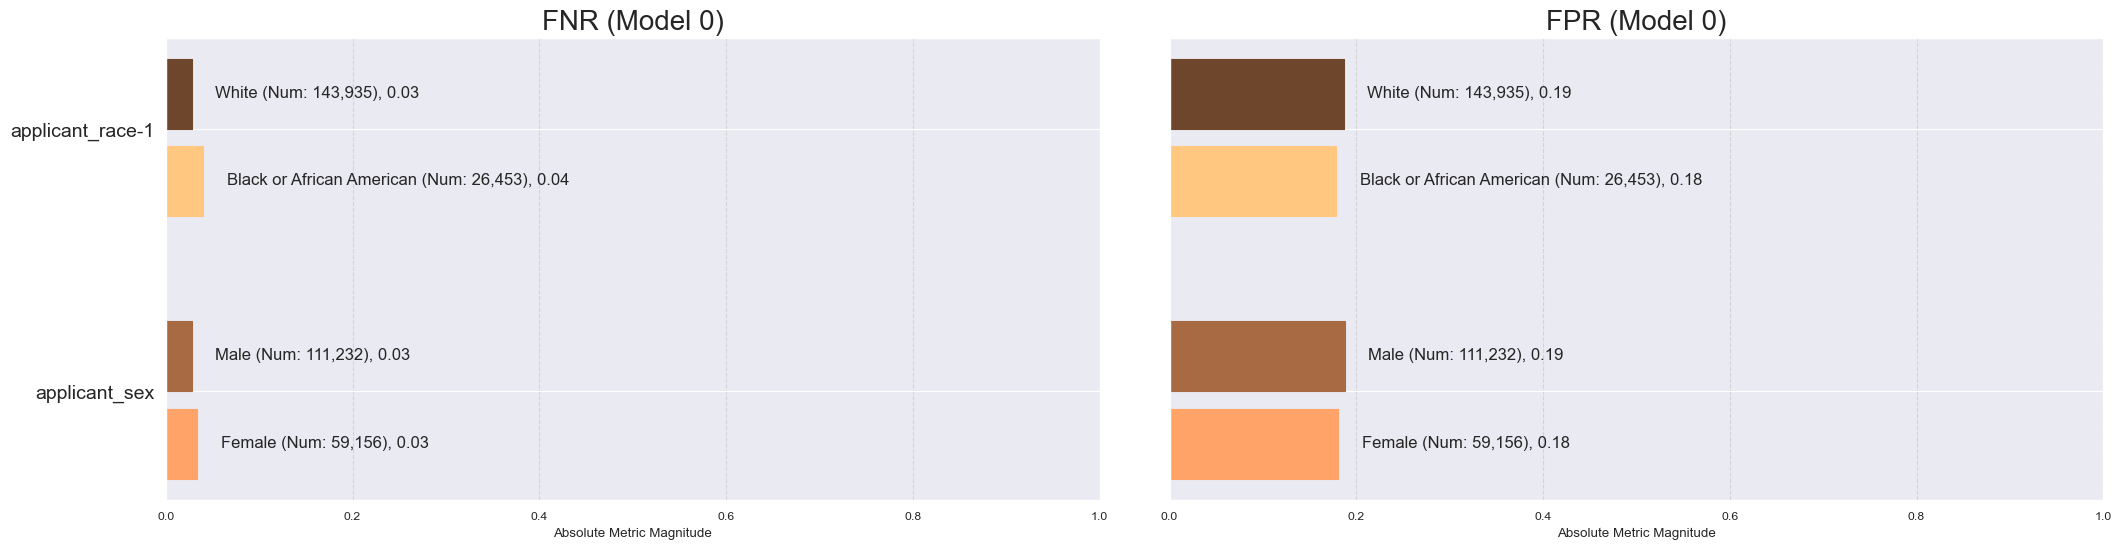

<Figure size 640x480 with 0 Axes>

In [45]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['fnr','fpr'], ncols=2)

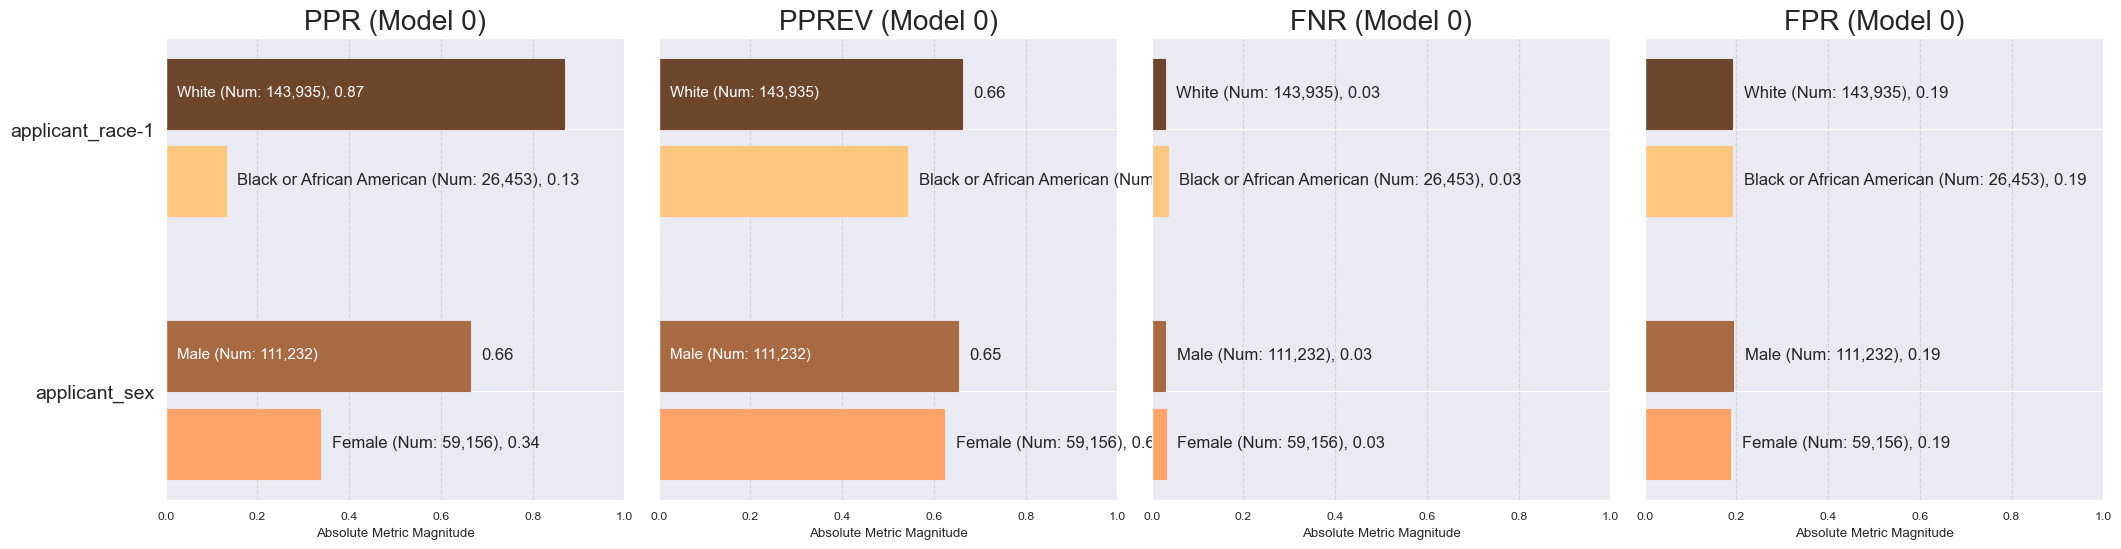

<Figure size 640x480 with 0 Axes>

In [46]:
group_metric_all_rew = aqp.plot_group_metric_all(xtab_rew, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [47]:
b = aequitas.bias.Bias()

In [48]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

In [49]:
bdf_rew = b.get_disparity_predefined_groups(xtab_rew, original_df=results_ren_rew, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex': 'Male'}, alpha=0.05, mask_significance=True)
bdf_rew.style

In [50]:
original_model_results_total = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1': [f1_score(y_test, y_pred)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba)],
    'tpr_disparity': [bdf['tpr_disparity'][2]],
    'fpr_disparity': [bdf['fpr_disparity'][2]],
    'tnr_disparity': [bdf['tnr_disparity'][2]],
    'fnr_disparity': [bdf['fnr_disparity'][2]]
})

In [51]:
original_model_results_total

accuracy  precision    recall        f1   roc_auc  tpr_disparity  \
0  0.904894   0.878313  0.970316  0.922025  0.943971       0.987803   

   fpr_disparity  tnr_disparity  fnr_disparity  
0       0.955315       1.010275       1.419652

In [52]:
original_model_results_total_rew = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred_rew)],
    'precision': [precision_score(y_test, y_pred_rew)],
    'recall': [recall_score(y_test, y_pred_rew)],
    'f1': [f1_score(y_test, y_pred_rew)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba_rew)],
    'tpr_disparity': [bdf_rew['tpr_disparity'][2]],
    'fpr_disparity': [bdf_rew['fpr_disparity'][2]],
    'tnr_disparity': [bdf_rew['tnr_disparity'][2]],
    'fnr_disparity': [bdf_rew['fnr_disparity'][2]]
})

In [53]:
results_df = pd.concat([original_model_results_total, original_model_results_total_rew], axis=0)
results_df.index = ['Initial_Model', 'Iteration I']
results_df = results_df.T
results_df

Initial_Model  Iteration I
accuracy            0.904894     0.902493
precision           0.878313     0.875046
recall              0.970316     0.970296
f1                  0.922025     0.920212
roc_auc             0.943971     0.941941
tpr_disparity       0.987803     0.994071
fpr_disparity       0.955315     0.998854
tnr_disparity       1.010275     1.000271
fnr_disparity       1.419652     1.198473

In [54]:
results_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/result_frames/performance/results_df.pkl")

In [55]:
results_df["Initial_Model"][5]

0.9878028323563981

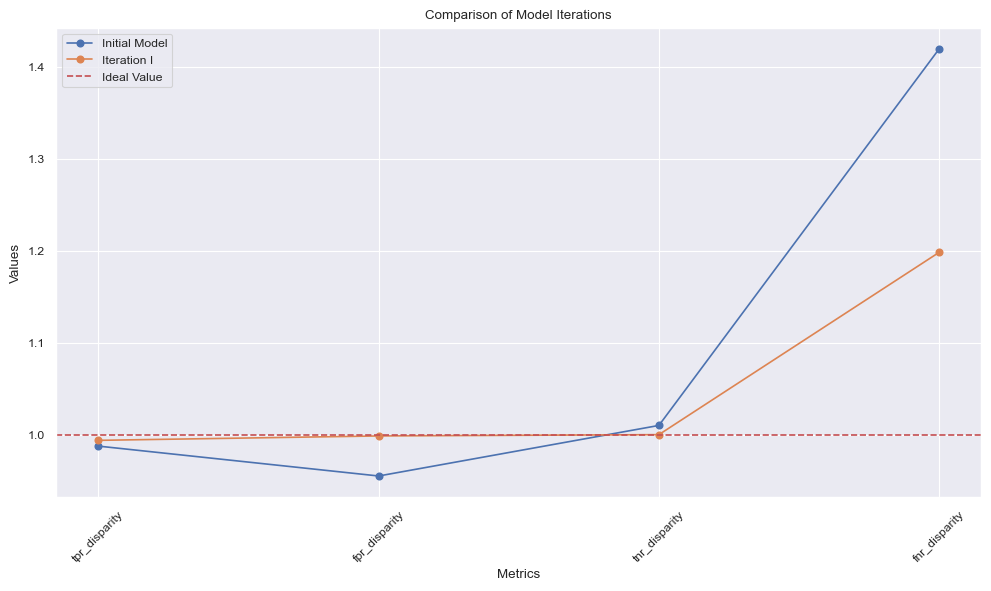

In [56]:
data = {
    'KPI': ['tpr_disparity', 'fpr_disparity', 'tnr_disparity', 'fnr_disparity'],
    'Initial_Model': [results_df["Initial_Model"][5], results_df["Initial_Model"][6], results_df["Initial_Model"][7], results_df["Initial_Model"][8]],
    'Iteration I': [results_df["Iteration I"][5], results_df["Iteration I"][6], results_df["Iteration I"][7], results_df["Iteration I"][8]]
}

df = pd.DataFrame(data)
metrics = df['KPI']
iteration1_values = df['Initial_Model']
iteration2_values = df['Iteration I']

# Plotting
plt.figure(figsize=(10, 6))

# Plot values for Iteration I
plt.plot(metrics, iteration1_values, marker='o', label='Initial Model')

# Plot values for Iteration II
plt.plot(metrics, iteration2_values, marker='o', label='Iteration I')

# Plot reference line at y=1
plt.axhline(y=1, color='r', linestyle='--', label='Ideal Value')

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Iterations')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
import shap

def f(X):
    return model.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [58]:
shap.initjs()
explainer = shap.KernelExplainer(model.predict ,shap.sample(X_train_scaled, 100))

4/4 [==============================] - 0s 2ms/step


In [59]:
shap.initjs()
tf.autograph.set_verbosity(0)
shap_values = explainer.shap_values(X_test_scaled[:150], nsamples=150)

  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 1s 1ms/step


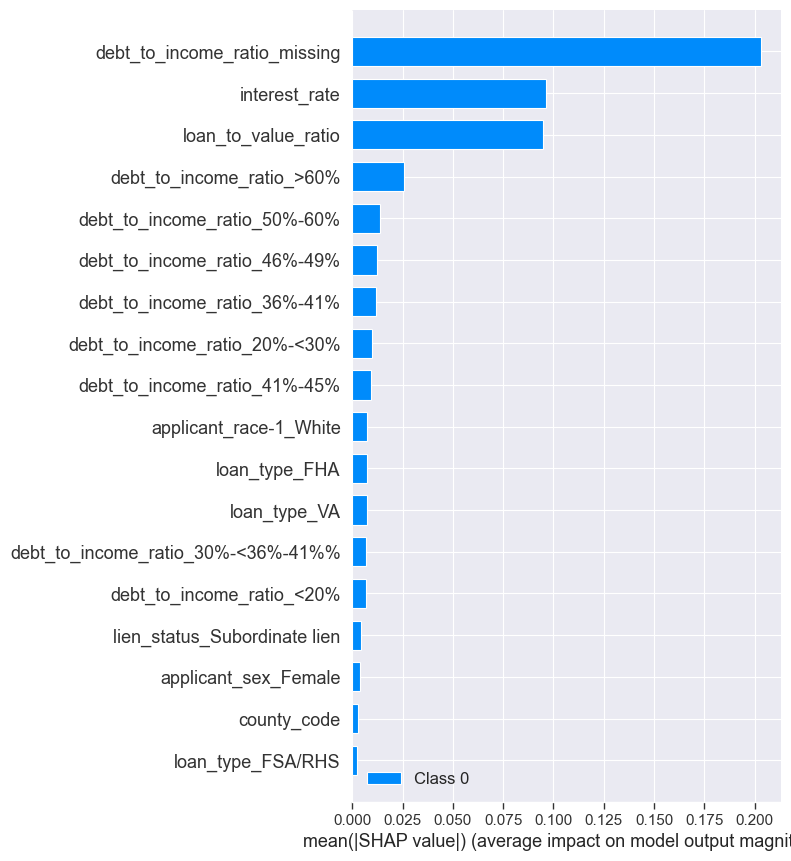

In [60]:
shap.summary_plot(shap_values, X_test_scaled[:150], feature_names=X.columns)

In [61]:
shap_values_single_test = explainer.shap_values(X_test_scaled[:1], nsamples=150)

  0%|          | 0/1 [00:00<?, ?it/s]

469/469 [==============================] - 1s 1ms/step


In [62]:
shap.summary_plot(shap_values_single_test, X_test_scaled[:1], feature_names=X.columns, plot_type="dot")

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!

In [ ]:
# pd.DataFrame(sorted(dict(zip(X.columns, shap_values[0][0])).items(), key=lambda x: x[1], reverse=True))

# recreate the dataframe with the mean shap values for X_test[:150]
shap_values_df = pd.DataFrame(shap_values[0], columns=X.columns)
shap_values_df_mean = shap_values_df.abs().mean()
shap_values_df_mean.sort_values(ascending=False, inplace=True)

pd.DataFrame(shap_values_df_mean)

# create a dataframe from shap_values_df_mean where the feature names are a column and the values are a separate column
shap_values_df_mean = shap_values_df_mean.reset_index()
shap_values_df_mean.columns = ['feature', 'shap_value']
shap_values_df_mean

feature  shap_value
0         debt_to_income_ratio_missing    0.203014
1                        interest_rate    0.096168
2                  loan_to_value_ratio    0.094977
3            debt_to_income_ratio_>60%    0.025548
4         debt_to_income_ratio_50%-60%    0.013568
5         debt_to_income_ratio_46%-49%    0.012372
6         debt_to_income_ratio_36%-41%    0.011655
7        debt_to_income_ratio_20%-<30%    0.009679
8         debt_to_income_ratio_41%-45%    0.009207
9               applicant_race-1_White    0.007540
10                       loan_type_FHA    0.007238
11                        loan_type_VA    0.007093
12  debt_to_income_ratio_30%-<36%-41%%    0.006920
13           debt_to_income_ratio_<20%    0.006867
14        lien_status_Subordinate lien    0.004146
15                applicant_sex_Female    0.003618
16                         county_code    0.002967
17                   loan_type_FSA/RHS    0.002285

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[:150], feature_names=X.columns, matplotlib=False)

In [ ]:
explainer.expected_value

array([0.56890215])

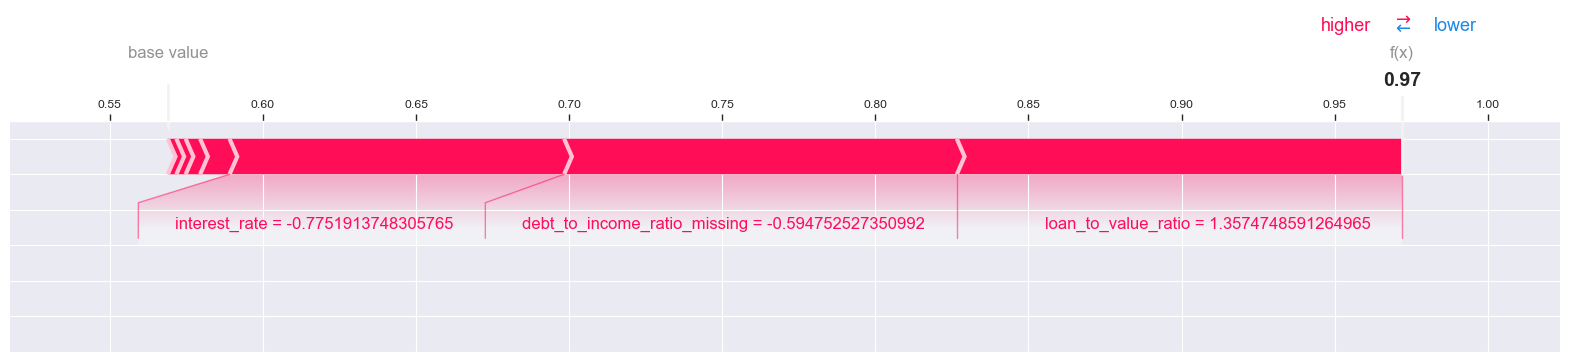

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

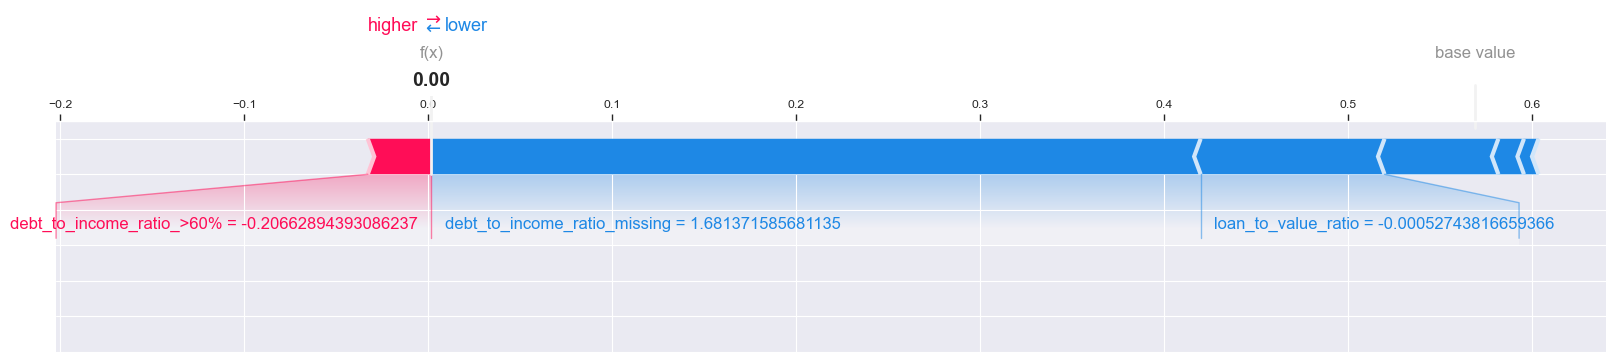

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][1], X_test_scaled[1], feature_names=X.columns, matplotlib=True)

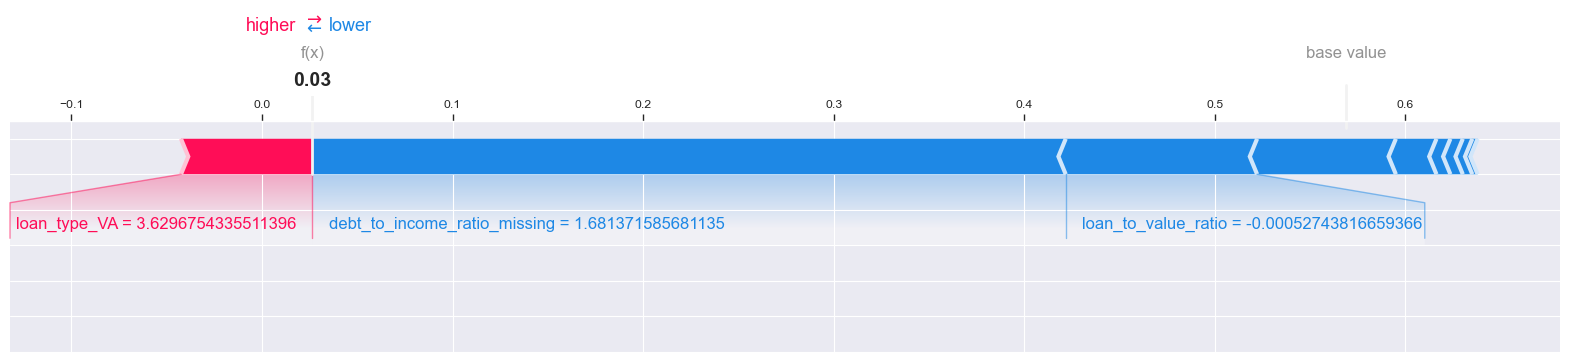

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][21], X_test_scaled[21], feature_names=X.columns, matplotlib=True)

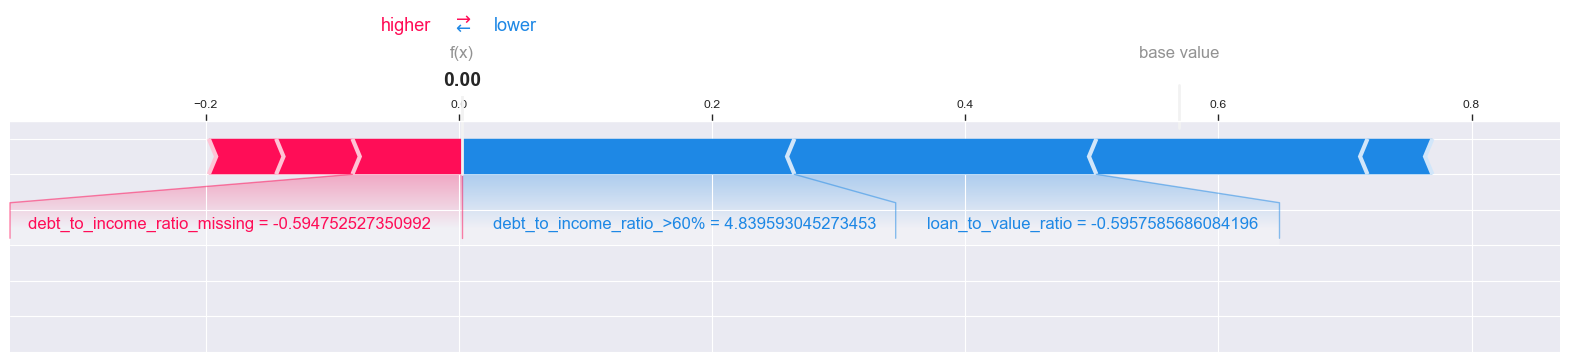

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][139], X_test_scaled[139], feature_names=X.columns, matplotlib=True, contribution_threshold=0.1)

In [ ]:
# select rows 0,1,21,51 from X_test
X_test.iloc[[0, 1, 21, 139]]

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
238575       48167       3.625000            96.404000                 False   
328268       49035       4.560661            71.241202                 False   
335557       48453       4.560661            71.241202                 False   
414582       48139       4.170560            60.212000                 False   

        applicant_race-1_White  loan_type_FHA  loan_type_VA  \
238575                    True          False         False   
328268                    True          False         False   
335557                   False          False          True   
414582                   False          False         False   

        loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
238575              False                          False   
328268              False                          False   
335557              False                          False   
414582              False                          False   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
238575                               False                          True   
328268                               False                         False   
335557                               False                         False   
414582                               False                         False   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
238575                         False                         False   
328268                         False                         False   
335557                         False                         False   
414582                         False                         False   

        debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
238575                         False                      False   
328268                         False                      False   
335557                         False                      False   
414582                         False                      False   

        debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
238575                      False                         False   
328268                      False                          True   
335557                      False                          True   
414582                       True                         False   

        lien_status_Subordinate lien  
238575                         False  
328268                         False  
335557                         False  
414582                          True

In [ ]:
# find the correlation of debt_to_income_ratio_missing and applicant_race-1_White in X_train_scaled
np.corrcoef(X_train_scaled[:, 3], X_train_scaled[:, 5])

array([[1.        , 0.08161616],
       [0.08161616, 1.        ]])

In [ ]:
X_test.reset_index(drop=True, inplace=False)[X_test.reset_index(drop=True, inplace=False)["debt_to_income_ratio_missing"] == 0].head(130).tail(50)

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
105       48157       6.000000            73.975000                 False   
106       48439       4.560661            71.241202                  True   
108       48339       3.375000            25.595000                 False   
110       48251       0.000000             0.000000                 False   
111       22105       4.990000            53.967000                  True   
112       22063       3.875000            80.000000                 False   
113       48245       4.560661            71.241202                  True   
114       48029       3.985505            54.980000                 False   
115       48113       4.347692            65.220000                 False   
116       48491       5.000000            80.000000                  True   
117       49035       4.560661            71.241202                 False   
120       48251       4.560661            71.241202                 False   
121       48441       4.560661            71.241202                 False   
123       46099       4.560661            71.241202                  True   
124       48439       4.560661            71.241202                 False   
126       48157       4.560661            71.241202                 False   
130       30041       4.560661            71.241202                  True   
131       22051       4.560661            71.241202                  True   
132       22063       0.000000             0.000000                 False   
133       48157       3.896374            52.460000                 False   
134       48113       7.625000            95.000000                 False   
135       48201       4.560661            71.241202                 False   
136       48491       3.250000            60.333378                 False   
139       48139       4.170560            60.212000                 False   
141       22071       4.919975            81.400000                 False   
143       49057       4.560661            71.241202                 False   
145       49043       4.490000            82.060000                 False   
148       48141       3.929975            53.410000                  True   
152       48303       4.560661            71.241202                  True   
153       48085       4.421615            67.310000                 False   
154       49049       4.560661            71.241202                  True   
155       48467       4.560661            71.241202                 False   
156       48121       4.560661            71.241202                 False   
157       48085       4.560661            71.241202                 False   
159       22103       4.560661            71.241202                  True   
160       48257       3.875000            80.000000                 False   
161       48167       4.560661            71.241202                 False   
163       48397       4.560661            71.241202                 False   
165       48027       6.000000            96.500000                 False   
166       22053       4.560661            71.241202                  True   
170       48085       5.375000            89.150000                 False   
172       48121       5.613294           101.002000                 False   
173       30063       4.000000            60.000000                 False   
176       48127       4.560661            71.241202                  True   
177       48443       6.250000           100.000000                 False   
178       49011       4.560661            71.241202                  True   
179       48201       1.990000            32.690000                  True   
180       49053       3.375000            80.000000                  True   
181       48209       4.560661            71.241202                  True   
183       48329       5.375000            90.000000                 False   

     applicant_race-1_White  loan_type_FHA  loan_type_VA  loan_type_FSA/RHS 

In [ ]:
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

0: Base value [0.56890215] Shapley value 0.40315436088712897 Sum [0.97205651]
1: Base value [0.56890215] Shapley value -0.567157442739699 Sum [0.0017447]
2: Base value [0.56890215] Shapley value 0.38816552126081666 Sum [0.95706767]
3: Base value [0.56890215] Shapley value 0.2166162606445141 Sum [0.78551841]
4: Base value [0.56890215] Shapley value -0.4452240813407117 Sum [0.12367807]
5: Base value [0.56890215] Shapley value -0.5671393680968322 Sum [0.00176278]
6: Base value [0.56890215] Shapley value 0.3811581011977978 Sum [0.95006025]
7: Base value [0.56890215] Shapley value 0.3741783376899547 Sum [0.94308048]
8: Base value [0.56890215] Shapley value 0.3794875618186779 Sum [0.94838971]
9: Base value [0.56890215] Shapley value 0.023741888639051467 Sum [0.59264404]


In [ ]:
y_pred_proba[:10]

array([0.9720565 , 0.00174471, 0.95706767, 0.78551847, 0.12367814,
       0.00176278, 0.9500603 , 0.9430805 , 0.9483897 , 0.59264404],
      dtype=float32)

In [ ]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0                  loan_to_value_ratio  0.145456
1         debt_to_income_ratio_missing  0.128256
2                        interest_rate  0.109283
3            debt_to_income_ratio_>60%  0.009597
4               applicant_race-1_White  0.004734
5         debt_to_income_ratio_41%-45%  0.003025
6         debt_to_income_ratio_46%-49%  0.002804
7                          county_code  0.000000
8                 applicant_sex_Female  0.000000
9                        loan_type_FHA  0.000000
10                        loan_type_VA  0.000000
11                   loan_type_FSA/RHS  0.000000
12       debt_to_income_ratio_20%-<30%  0.000000
13  debt_to_income_ratio_30%-<36%-41%%  0.000000
14        debt_to_income_ratio_36%-41%  0.000000
15        debt_to_income_ratio_50%-60%  0.000000
16           debt_to_income_ratio_<20%  0.000000
17        lien_status_Subordinate lien  0.000000

In [ ]:
explainer_rew = shap.KernelExplainer(model_rew.predict ,shap.sample(X_train_scaled, 100))
shap_values_rew = explainer_rew.shap_values(X_test_scaled[:150], nsamples=150)

4/4 [==============================] - 0s 3ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 1s 1ms/step


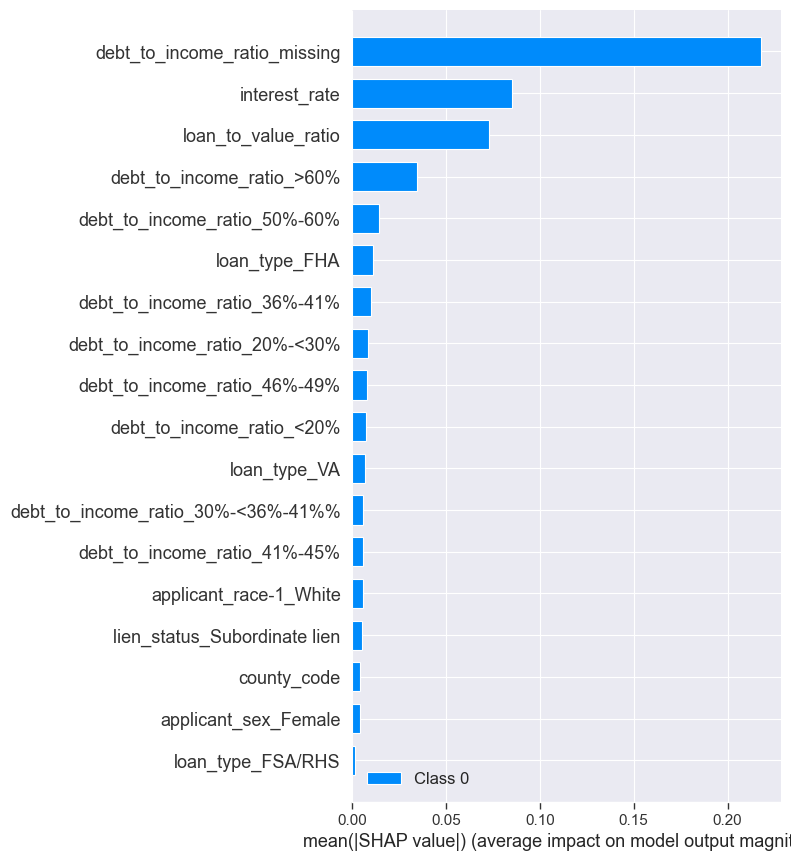

In [ ]:
shap.summary_plot(shap_values_rew, X_test_scaled[:150], feature_names=X.columns)

In [ ]:
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0], X_test_scaled[:150], feature_names=X.columns, matplotlib=False)

In [ ]:
explainer_rew.expected_value

array([0.57328115])

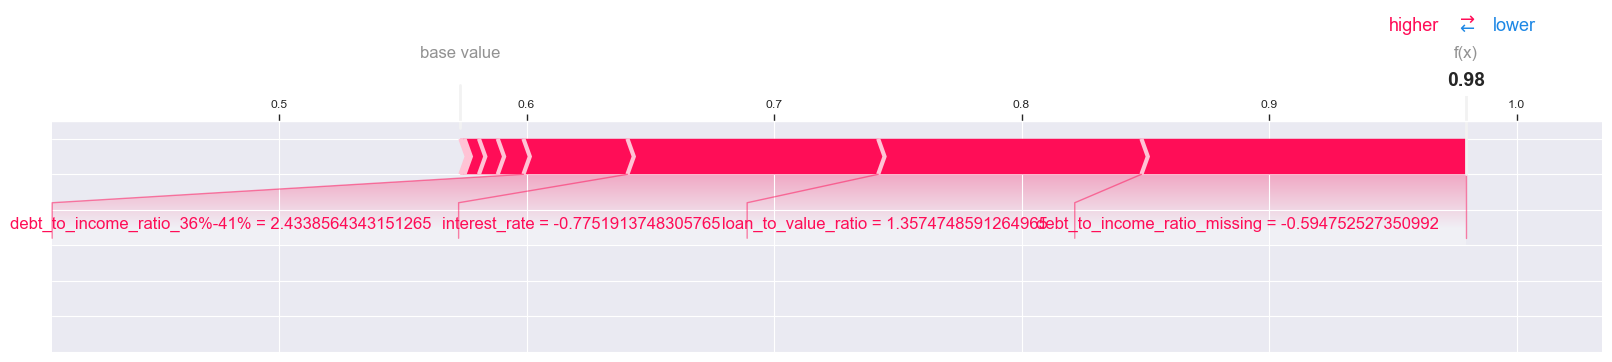

In [ ]:
shap.initjs()
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [ ]:
print("Reweighed")
for value in range(10):
    print(str(value) + ": Base value", explainer_rew.expected_value, "Shapley value", shap_values_rew[0][value].sum(), "Sum", shap_values_rew[0][value].sum() + explainer_rew.expected_value)
print("Original")
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

Reweighed
0: Base value [0.57328115] Shapley value 0.40629519947455256 Sum [0.97957635]
1: Base value [0.57328115] Shapley value -0.5697244202566799 Sum [0.00355673]
2: Base value [0.57328115] Shapley value 0.3721053195802961 Sum [0.94538647]
3: Base value [0.57328115] Shapley value 0.09970988758490418 Sum [0.67299104]
4: Base value [0.57328115] Shapley value -0.10993630758835937 Sum [0.46334484]
5: Base value [0.57328115] Shapley value -0.5697131065500435 Sum [0.00356804]
6: Base value [0.57328115] Shapley value 0.38131614454672674 Sum [0.95459729]
7: Base value [0.57328115] Shapley value 0.3677002383081708 Sum [0.94098139]
8: Base value [0.57328115] Shapley value 0.3762632799951825 Sum [0.94954443]
9: Base value [0.57328115] Shapley value 0.19519164093420838 Sum [0.76847279]
Original
0: Base value [0.56890215] Shapley value 0.40315436088712897 Sum [0.97205651]
1: Base value [0.56890215] Shapley value -0.567157442739699 Sum [0.0017447]
2: Base value [0.56890215] Shapley value 0.388165

In [ ]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values_rew[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0         debt_to_income_ratio_missing  0.131126
1                  loan_to_value_ratio  0.106364
2                        interest_rate  0.101312
3         debt_to_income_ratio_36%-41%  0.042019
4   debt_to_income_ratio_30%-<36%-41%%  0.010385
5         debt_to_income_ratio_50%-60%  0.007586
6            debt_to_income_ratio_>60%  0.005842
7         debt_to_income_ratio_46%-49%  0.001420
8            debt_to_income_ratio_<20%  0.000242
9                          county_code  0.000000
10                applicant_sex_Female  0.000000
11              applicant_race-1_White  0.000000
12                       loan_type_FHA  0.000000
13                        loan_type_VA  0.000000
14                   loan_type_FSA/RHS  0.000000
15       debt_to_income_ratio_20%-<30%  0.000000
16        debt_to_income_ratio_41%-45%  0.000000
17        lien_status_Subordinate lien  0.000000

In [ ]:
shap_diff_race_orig = []
for i in range(15):
    shap_diff_race_orig.append(shap_values[0][i][4])

shap_diff_race_rew = []
for i in range(15):
    shap_diff_race_rew.append(shap_values_rew[0][i][4])

pd.DataFrame({'Original': shap_diff_race_orig, 'Reweighed': shap_diff_race_rew})

Original  Reweighed
0   0.004734   0.000000
1   0.000000   0.000000
2   0.000000   0.000000
3   0.025521   0.007608
4  -0.040969   0.000000
5   0.000000   0.000000
6   0.000000   0.000000
7   0.000000   0.000000
8   0.000000   0.000000
9   0.000000   0.000000
10 -0.032074  -0.023840
11  0.000000   0.000000
12 -0.076654  -0.039208
13  0.000000   0.001899
14 -0.020231  -0.020780

In [ ]:
import lime.lime_tabular

In [ ]:
lime_exp = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, mode="classification", feature_names=X.columns)

In [ ]:
explained_lime = lime_exp.explain_instance(X_test_scaled[0], model.predict, num_features=15, top_labels=1)

157/157 [==============================] - 0s 882us/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


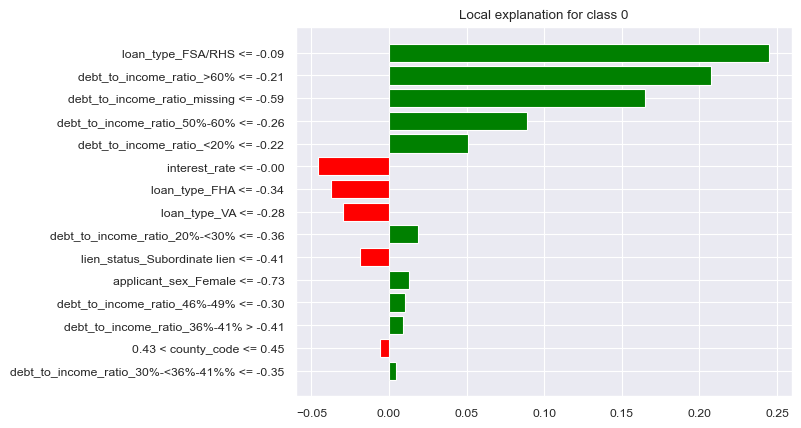

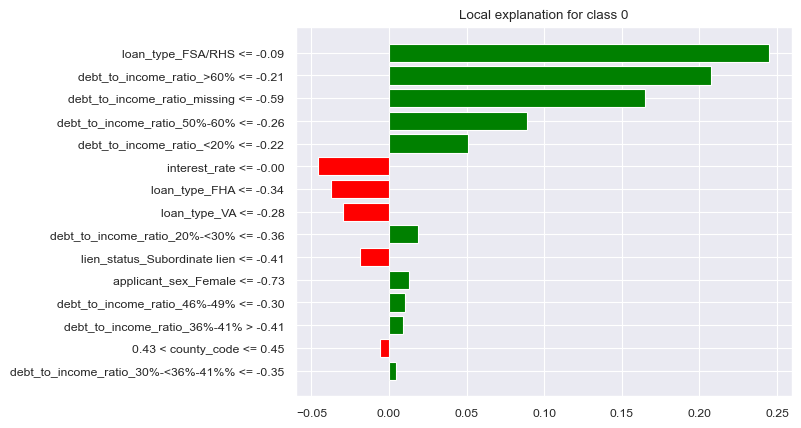

In [ ]:
explained_lime.as_pyplot_figure(label=0)

  1/157 [..............................] - ETA: 2s

157/157 [==============================] - 0s 1ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


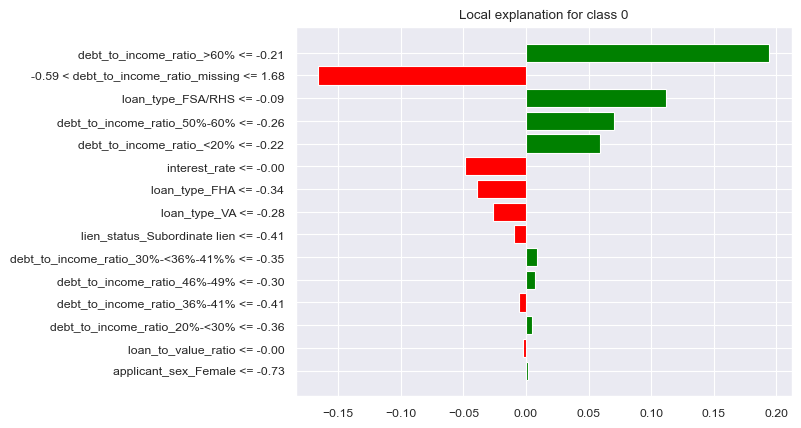

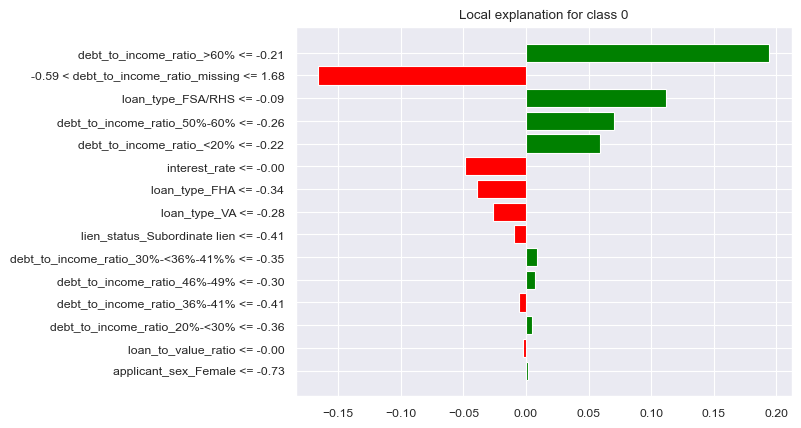

In [ ]:
explained_lime_1 = lime_exp.explain_instance(X_test_scaled[1], model.predict, num_features=15, top_labels=1)
explained_lime_1.as_pyplot_figure(label=0)

In [ ]:
explained_lime.as_html()

'<html>\n        <meta http-equiv="content-type" content="text/html; charset=UTF8">\n        <head><script>var lime =\n/******/ (function(modules) { // webpackBootstrap\n/******/ \t// The module cache\n/******/ \tvar installedModules = {};\n/******/\n/******/ \t// The require function\n/******/ \tfunction __webpack_require__(moduleId) {\n/******/\n/******/ \t\t// Check if module is in cache\n/******/ \t\tif(installedModules[moduleId])\n/******/ \t\t\treturn installedModules[moduleId].exports;\n/******/\n/******/ \t\t// Create a new module (and put it into the cache)\n/******/ \t\tvar module = installedModules[moduleId] = {\n/******/ \t\t\texports: {},\n/******/ \t\t\tid: moduleId,\n/******/ \t\t\tloaded: false\n/******/ \t\t};\n/******/\n/******/ \t\t// Execute the module function\n/******/ \t\tmodules[moduleId].call(module.exports, module, module.exports, __webpack_require__);\n/******/\n/******/ \t\t// Flag the module as loaded\n/******/ \t\tmodule.loaded = true;\n/******/\n/******/ 

In [ ]:
explained_lime.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# !!!
lime_features_list = ["loan_type_FSA/RHS",
                      "debt_to_income_ratio_>60%",
                      "debt_to_income_ratio_missing",
                      "debt_to_income_ratio_50%-60%",
                      "debt_to_income_ratio_<20%",
                      "interest_rate",
                      "loan_type_FHA",
                      "loan_type_VA",
                      "debt_to_income_ratio_20%-<30%",
                      "lien_status_Subordinate lien",
                      "applicant_sex_Female",
                      "debt_to_income_ratio_46%-49%",
                      "debt_to_income_ratio_36%-41%",
                      "county_code",
                      "debt_to_income_ratio_30%-<36%-41%%"]

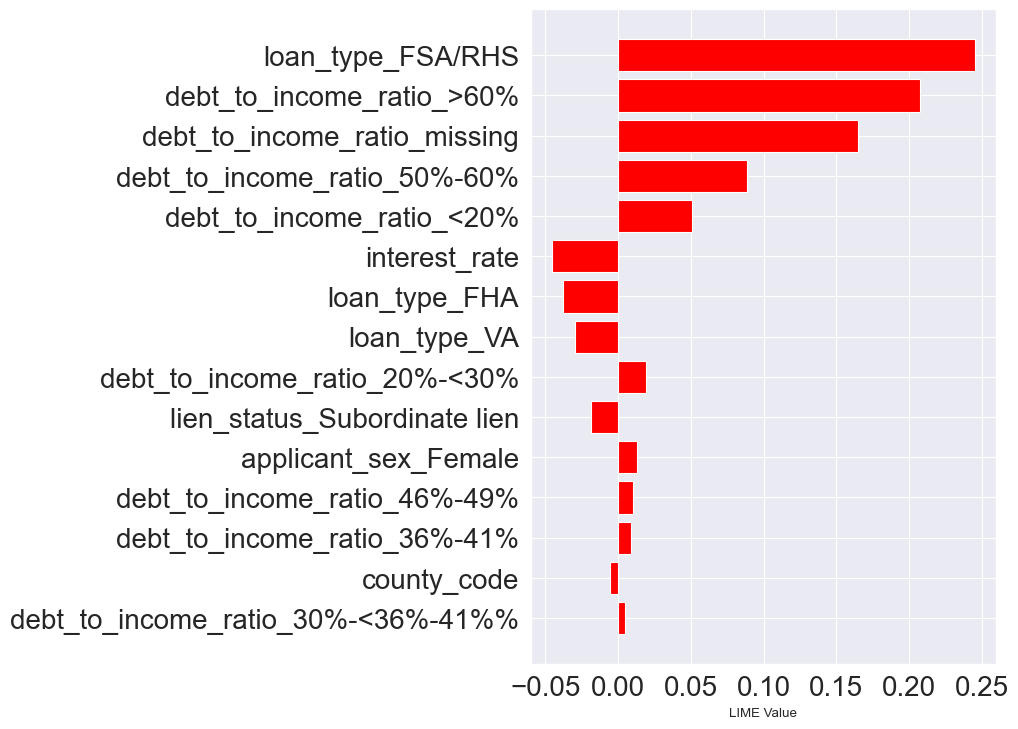

In [ ]:
lime_values_list = []

for i in range(15):
    lime_values_list.append(explained_lime.local_exp[0][i][1])

lime_results_df = pd.DataFrame({"Feature Name": lime_features_list, "Value": lime_values_list})

lime_results_df = lime_results_df.reindex(lime_results_df["Value"].abs().sort_values(ascending=True).index)

plt.figure(figsize=(6, 8.5))
plt.barh(lime_results_df["Feature Name"], lime_results_df["Value"], color='red')
plt.xlabel('LIME Value')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

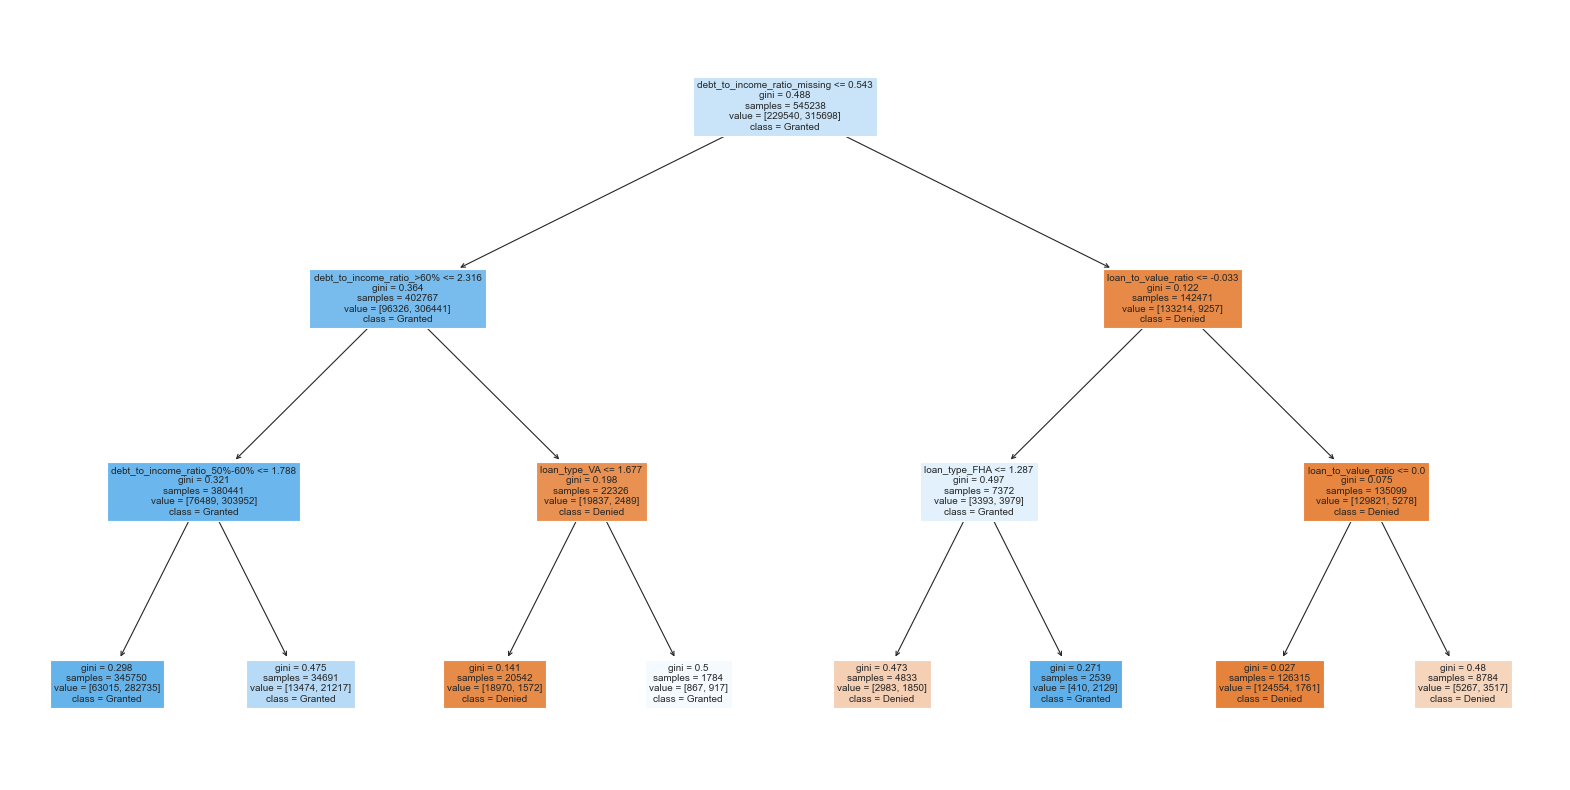

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_scaled, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, filled=True, class_names=['Denied', 'Granted'])
plt.show()

In [ ]:
X_train_original = X_train_scaled
X_val_original = X_val_scaled
X_test_original = X_test_scaled
y_train_original = y_train
y_val_original = y_val

from sklearn.tree import DecisionTreeClassifier
surrogate_model = DecisionTreeClassifier()

surrogate_model.fit(X_train_original, y_train_original)

surrogate_accuracy = surrogate_model.score(X_test_original, y_test)
feature_importance = surrogate_model.feature_importances_

In [ ]:
surrogate_accuracy

0.8924982980022067

In [ ]:
surrogate_df = X_test.copy()
surrogate_df['prediction'] = surrogate_model.predict(X_test_original)

surrogate_df_white = surrogate_df[mask_white]
surrogate_df_black = surrogate_df[mask_black]

comp_df = comp_df_orig_rew.assign(Surrogate = [accuracy_score(y_test_white, surrogate_df_white['prediction']), 
                                     precision_score(y_test_white, surrogate_df_white['prediction']),
                                     recall_score(y_test_white, surrogate_df_white['prediction']),
                                     f1_score(y_test_white, surrogate_df_white['prediction']),
                                     "NA",
                                     accuracy_score(y_test_black, surrogate_df_black['prediction']),
                                     precision_score(y_test_black, surrogate_df_black['prediction']),
                                     recall_score(y_test_black, surrogate_df_black['prediction']),
                                     f1_score(y_test_black, surrogate_df_black['prediction']),
                                     "NA"])

In [ ]:
cm = confusion_matrix(y_test, surrogate_df['prediction'])
print(cm)

[[60385 11263]
 [ 7054 91686]]


In [ ]:
comp_df

Original  Reweighted Surrogate
Accuracy White   0.908695    0.906631  0.895995
Precision White  0.887436    0.885204  0.896901
Recall White     0.971756    0.970995  0.934889
F1 Score White   0.927684    0.926117  0.915501
AUC White        0.941588    0.940123        NA
Accuracy Black   0.884210    0.879976  0.873474
Precision Black  0.816840    0.807631  0.845104
Recall Black     0.959903    0.965238  0.882794
F1 Score Black   0.882612    0.879429  0.863538
AUC Black        0.947980    0.947376        NA

In [ ]:
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df

feature  importance
16        debt_to_income_ratio_missing    0.464715
1                        interest_rate    0.155019
2                  loan_to_value_ratio    0.142914
15           debt_to_income_ratio_>60%    0.090883
0                          county_code    0.063720
6                         loan_type_VA    0.016108
5                        loan_type_FHA    0.014240
13        debt_to_income_ratio_50%-60%    0.012217
3                 applicant_sex_Female    0.008247
4               applicant_race-1_White    0.006562
17        lien_status_Subordinate lien    0.006549
14           debt_to_income_ratio_<20%    0.003728
10        debt_to_income_ratio_36%-41%    0.003069
9   debt_to_income_ratio_30%-<36%-41%%    0.002883
8        debt_to_income_ratio_20%-<30%    0.002845
11        debt_to_income_ratio_41%-45%    0.002777
12        debt_to_income_ratio_46%-49%    0.002632
7                    loan_type_FSA/RHS    0.000889

In [ ]:
global_surrogate_model = DecisionTreeClassifier()
global_surrogate_model.fit(X_train_original, y_train_original)

global_surrogate_accuracy = global_surrogate_model.score(X_test_original, y_pred)
global_feature_importance = global_surrogate_model.feature_importances_

In [ ]:
global_surrogate_accuracy

0.9405063736882879

In [ ]:
global_feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': global_feature_importance})
global_feature_importance_df = global_feature_importance_df.sort_values('importance', ascending=False)
global_feature_importance_df

feature  importance
16        debt_to_income_ratio_missing    0.464715
1                        interest_rate    0.155027
2                  loan_to_value_ratio    0.143212
15           debt_to_income_ratio_>60%    0.090883
0                          county_code    0.063472
6                         loan_type_VA    0.016107
5                        loan_type_FHA    0.014223
13        debt_to_income_ratio_50%-60%    0.012217
3                 applicant_sex_Female    0.008055
4               applicant_race-1_White    0.006572
17        lien_status_Subordinate lien    0.006537
14           debt_to_income_ratio_<20%    0.003678
10        debt_to_income_ratio_36%-41%    0.003252
9   debt_to_income_ratio_30%-<36%-41%%    0.002850
12        debt_to_income_ratio_46%-49%    0.002783
8        debt_to_income_ratio_20%-<30%    0.002773
11        debt_to_income_ratio_41%-45%    0.002739
7                    loan_type_FSA/RHS    0.000904

In [ ]:
merged_weights_df = pd.merge(global_feature_importance_df, lime_results_df, left_on="feature", right_on = "Feature Name")
merged_weights_df = merged_weights_df.drop(columns="Feature Name")
merged_weights_df.columns = ["Feature", "Global Surrogate Model", "LIME"]
merged_weights_df = merged_weights_df.merge(shap_values_df_mean, left_on = "Feature", right_on = "feature")
merged_weights_df = merged_weights_df.drop(columns="feature")
merged_weights_df.columns = ["Feature", "Global Surrogate Model", "LIME", "SHAP"]
merged_weights_df["LIME"] = merged_weights_df["LIME"].abs()
merged_weights_df = merged_weights_df.sort_values(by="Global Surrogate Model", ascending=False)
merged_weights_df

Feature  Global Surrogate Model      LIME  \
0         debt_to_income_ratio_missing                0.464715  0.164703   
1                        interest_rate                0.155027  0.045576   
2            debt_to_income_ratio_>60%                0.090883  0.207288   
3                          county_code                0.063472  0.005685   
4                         loan_type_VA                0.016107  0.029364   
5                        loan_type_FHA                0.014223  0.037538   
6         debt_to_income_ratio_50%-60%                0.012217  0.088851   
7                 applicant_sex_Female                0.008055  0.012949   
8         lien_status_Subordinate lien                0.006537  0.018472   
9            debt_to_income_ratio_<20%                0.003678  0.050694   
10        debt_to_income_ratio_36%-41%                0.003252  0.009069   
11  debt_to_income_ratio_30%-<36%-41%%                0.002850  0.004697   
12        debt_to_income_ratio_46%-49%                0.002783  0.010349   
13       debt_to_income_ratio_20%-<30%                0.002773  0.018872   
14                   loan_type_FSA/RHS                0.000904  0.245002   

        SHAP  
0   0.203014  
1   0.096168  
2   0.025548  
3   0.002967  
4   0.007093  
5   0.007238  
6   0.013568  
7   0.003618  
8   0.004146  
9   0.006867  
10  0.011655  
11  0.006920  
12  0.012372  
13  0.009679  
14  0.002285

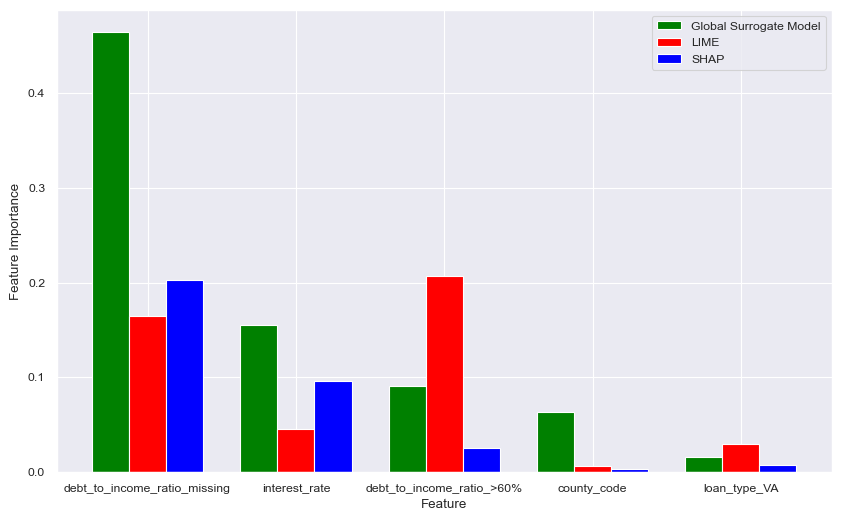

In [ ]:
# Sort the DataFrame by the 'Feature' column
# merged_weights_df = merged_weights_df.sort_values('Feature')

# Number of bars (features) to display
num_bars = 5

# Create an array with the positions of each bar
bar_positions = np.arange(num_bars)

# Set the width of each bar
bar_width = 0.25

# Create the figure
plt.figure(figsize=(10, 6))

# Plot the bars for each model, adjusting the position for each one
plt.bar(bar_positions - bar_width, merged_weights_df["Global Surrogate Model"][:num_bars], color='green', label='Global Surrogate Model', width=bar_width)
plt.bar(bar_positions, merged_weights_df["LIME"][:num_bars], color='red', label='LIME', width=bar_width)
plt.bar(bar_positions + bar_width, merged_weights_df["SHAP"][:num_bars], color='blue', label='SHAP', width=bar_width)

# Set the y-ticks to be the feature names
plt.xticks(bar_positions, merged_weights_df["Feature"][:num_bars])

plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.legend()
plt.show()

In [ ]:
X_train_scaled

array([[-1.44813610e+00,  3.55598300e-01,  1.55154613e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.43057973e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.39506631e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00,  2.46483423e+00],
       ...,
       [ 5.41033231e-01, -1.39650438e+00, -1.05098414e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.66037244e-01, -8.78743543e-01, -4.76921098e-01, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01],
       [-2.28186586e+00, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01]])

In [ ]:
import lightgbm as lgb

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb

X_train_scaled_df = pd.DataFrame(X_train_scaled)

print(X_train_scaled_df.dtypes)

print(np.isnan(X_train_scaled).sum())

S = np.array([1 if i == 0 else 0 for i in X_train['applicant_race-1_White']])

print(len(S), len(X_train_scaled))

train_data = lgb.Dataset(X_train_scaled, label=y_train)

constraint = lgb.Dataset(X_train_scaled, label=y_train, group=S)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 3,
    "min_data_in_leaf": 2,
    "feature_fraction": 1.0,
    "random_state": 42,
    "verbose": -1  
}

try:
    fairgbm_mod = lgb.train(params, train_data, valid_sets=[constraint])
    y_pred_fairgbm = fairgbm_mod.predict(X_test_scaled)
except Exception as e: 
    print("Error:", e)


0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
dtype: object
0
545238 545238


Found `n_estimators` in params. Will use it instead of argument


Error: Sum of query counts (545238) differs from the length of #data (84175)


In [ ]:
print("Length of X_train_scaled:", len(X_train_scaled))
print("Length of S:", len(S))


Length of X_train_scaled: 545238
Length of S: 545238


### CIU Test

In [ ]:
# import ciu

In [ ]:
# X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
# X_test_df

In [ ]:
'''inst_ind = 42
instance = X_test_df.iloc[inst_ind]
inst_class = y_test.iloc[inst_ind]
pred = y_pred[inst_ind].astype(int)
print("Model prediction:", pred[0], "True label:", inst_class)'''

'inst_ind = 42\ninstance = X_test_df.iloc[inst_ind]\ninst_class = y_test.iloc[inst_ind]\npred = y_pred[inst_ind].astype(int)\nprint("Model prediction:", pred[0], "True label:", inst_class)'

In [ ]:
# print(instance.shape, inst_class.shape)

In [ ]:
# ciu_model = ciu.CIU(model.predict, HMDA_clean_final["loan_granted"].astype("category").cat.categories.tolist(), X_train)

In [ ]:
# CIUres = ciu_model.explain(instance)